# Question 2

How do we predict the suicide rates for different countries (and global) using factors such as GDP per capita and Life Expectancy? Under what composition of factors will lead to high suicide rates? Which ML model has more advantages when predicting suicide rates?

Finished by Jimmy Yang

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import math

In [2]:
def data_cleaning() -> pd.DataFrame:
    """
    A function returns the dataframe that will use on the whole
    question
    """
    # Read the happiness dataset from 2015 to 2019 and rename some
    # of the column names.
    happiness19_df = pd.read_csv('Data/2019.csv')
    happiness19_df.rename(columns={
        'Country or region': 'Country',
        'Freedom to make life choices': 'Freedom',
        'Score': 'Happiness Score'
        }, inplace=True)
    happiness19_df['Year'] = 2019

    happiness18_df = pd.read_csv('Data/2018.csv')
    happiness18_df.rename(columns={
        'Country or region': 'Country',
        'Freedom to make life choices': 'Freedom',
        'Score': 'Happiness Score'}, inplace=True)
    happiness18_df['Year'] = 2018

    happiness17_df = pd.read_csv('Data/2017.csv')
    happiness17_df.rename(columns={
        'Happiness.Score': 'Happiness Score',
        'Economy..GDP.per.Capita.': 'GDP per capita',
        'Health..Life.Expectancy.': 'Healthy life expectancy'
        }, inplace=True)
    happiness17_df['Year'] = 2017

    happiness16_df = pd.read_csv('Data/2016.csv')
    happiness16_df.rename(columns={
        'Economy (GDP per Capita)': 'GDP per capita',
        'Health (Life Expectancy)': 'Healthy life expectancy'
        }, inplace=True)
    happiness16_df['Year'] = 2016

    happiness15_df = pd.read_csv('Data/2015.csv')
    happiness15_df.rename(columns={
        'Economy (GDP per Capita)': 'GDP per capita',
        'Health (Life Expectancy)': 'Healthy life expectancy'
        }, inplace=True)
    happiness15_df['Year'] = 2015

    # Combine all the happiness dataset
    frames = [happiness19_df, happiness18_df, happiness17_df,
              happiness16_df, happiness15_df]
    happiness_15_to_19 = pd.concat(frames)
    happiness_15_to_19 = happiness_15_to_19[[
        'Overall rank', 'Country',
        'Happiness Score', 'GDP per capita',
        'Healthy life expectancy', 'Freedom',
        'Generosity', 'Year'
        ]]

    # read the suicides and countries dataset and marge them with
    # the happiness dataset
    suicides_df = pd.read_csv('Data/death-rate-from-suicides-gho.csv')
    suicides_df.rename(
        columns={'Age-standardized suicide rate - Sex: both sexes':
                 'suicide rate'},
        inplace=True)

    countries_df = pd.read_csv('Data/continents2.csv')
    countries_df = countries_df[['alpha-3', 'region']]

    marged = suicides_df.merge(happiness_15_to_19,
                               left_on=['Entity', 'Year'],
                               right_on=['Country', 'Year'])
    marged = marged.merge(countries_df, left_on='Code', right_on='alpha-3')

    # Add a new column claimming which countries have a suicide
    # rate that consider as high or low
    for i in marged.index:
        suicide = marged.loc[i, 'suicide rate']
        if suicide > 10:
            marged.loc[i, 'suicide high or low'] = 'High'
        else:
            marged.loc[i, 'suicide high or low'] = 'Low'

    return marged

In [3]:
def testing() -> None:
    """
    This is a test funtion for my dataset
    """
    df = data_cleaning()
    country = df['Entity'] == 'United States'
    US = df[country]
    US_suicide_avg = US['suicide rate'].mean()
    US_Happiness_Score_age = US['Happiness Score'].mean()

    assert math.isclose(US_suicide_avg, 13.90536)
    x = (6.892 + 6.886 + 6.99300003051758 + 7.104 + 7.119) / 5
    assert math.isclose(US_Happiness_Score_age, x)

In [4]:
def classifier_model(features, labels, model) -> tuple:
    """
    This is a helper function to train a classification model
    """
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3)

    model.fit(features_train, labels_train)

    # Accuracy
    train_pred = model.predict(features_train)
    train_acc = accuracy_score(labels_train, train_pred)

    test_pred = model.predict(features_test)
    test_acc = accuracy_score(labels_test, test_pred)
    return train_acc, test_acc

In [5]:
def predict_classification_suicide_rates_Global(
    happiness_suicide_df: pd.DataFrame
        ) -> None:
    """
    This is a ML model that can use to predict the suicide high or
    low column in the happiness_suicide_df for all the countries,
    countries with suicide rate higher than 10 consider as high,
    using different factors forms the happiness score as well as the
    happiness score itself.
    """
    global_df = happiness_suicide_df.copy()

    # Only keep the interested columns
    global_df = global_df[[
        'Happiness Score',
        'GDP per capita',
        'Healthy life expectancy',
        'Freedom',
        'suicide high or low'
        ]]

    # ML training
    model = DecisionTreeClassifier(max_depth=5)
    features = global_df.loc[
        :, global_df.columns != 'suicide high or low'
        ]
    features = pd.get_dummies(features)
    labels = global_df['suicide high or low']

    train_acc, test_acc = classifier_model(features, labels, model)

    print('Train accuracy for Global prediction:', train_acc)
    print('Test accuracy for Global prediction:', test_acc)

    # Plot the decision tree
    plt.figure(figsize=(45, 30))
    tree.plot_tree(
        model,
        feature_names=features.columns,
        class_names=labels.unique(),
        filled=True,
        fontsize=5
        )
    plt.title('Decision Tree For Global Classification ' +
              'Suicide Rate Prediction')
    plt.savefig('Global Classification Suicide Rate Prediction.png')
    plt.show()

In [6]:
def predict_classification_suicide_rates_regions(
    happiness_suicide_df: pd.DataFrame,
        region: str) -> None:
    """
    This is a ML model that can use to predict the suicide high or
    low column in the happiness_suicide_df for the countires in
    different regions, countries with suicide rate higher than 5
    consider as high, using different factors forms the happiness
    score as well as the happiness score itself.

    happiness_suicide_df: An organized dataframe for the prediction
    region: region that the user want to predict.
    """
    # Filter the dataset so that only Asia countires will be selected
    region_filter = happiness_suicide_df['region'] == region
    region_df = happiness_suicide_df[region_filter].copy()

    # Only keep the interested columns
    region_df = region_df[[
        'Happiness Score',
        'GDP per capita',
        'Healthy life expectancy',
        'Freedom',
        'suicide high or low'
        ]]

    # ML training
    model = DecisionTreeClassifier(max_depth=5)
    features = region_df.loc[
        :, region_df.columns != 'suicide high or low'
        ]
    labels = region_df['suicide high or low']

    train_acc, test_acc = classifier_model(features, labels, model)

    print('Train accuracy for', region, 'prediction:', train_acc)
    print('Test accuracy for', region, 'prediction:', test_acc)

In [7]:
def predict_regression_suicide_rates_Global(
    happiness_suicide_df: pd.DataFrame
        ) -> None:
    """
    This is a regression model that can use to predict the number of
    globalsuicide rates base on different factors forms the
    happinessscore as well as the happiness score itself.
    """
    global_df = happiness_suicide_df.copy()
    # Selecte the interested columbs
    global_df = global_df[[
        'suicide rate',
        'Happiness Score',
        'GDP per capita',
        'Healthy life expectancy',
        'Freedom'
        ]]
    # ML training
    features = global_df.loc[:, global_df.columns != 'suicide rate']
    labels = global_df['suicide rate']
    model = DecisionTreeRegressor(max_depth=10)
    model.fit(features, labels)
    error = mean_squared_error(model.predict(features), labels)

    print('Mean squared error for the regression model of global',
          'suicide rate predictions:', error)

    # Plot the decision tree
    plt.figure(figsize=(45, 30))
    tree.plot_tree(
        model,
        feature_names=features.columns,
        class_names=labels.unique(),
        filled=True,
        fontsize=5
        )
    plt.title('Decision Tree For Global Regression' +
              'Suicide Rate Prediction')
    plt.savefig('Global Regression Suicide Rate Prediction.png')
    plt.show()

In [8]:
def predict_regression_suicide_regions(
    happiness_suicide_df: pd.DataFrame,
    region: str
        ) -> None:
    """
    This is a regression model that can use to predict the number of
    suicide rates in different region based on different factors forms
    the happinessscore as well as the happiness score itself.

    happiness_suicide_df: An organized dataframe for the prediction
    region: region that the user want to predict.
    """
    region_filter = happiness_suicide_df['region'] == region
    region_df = happiness_suicide_df[region_filter].copy()
    region_df = region_df[[
        'suicide rate',
        'Happiness Score',
        'GDP per capita',
        'Healthy life expectancy',
        'Freedom'
        ]]

    features = region_df.loc[:, region_df.columns != 'suicide rate']
    labels = region_df['suicide rate']
    model = DecisionTreeRegressor(max_depth=10)
    model.fit(features, labels)
    error = mean_squared_error(model.predict(features), labels)
    print('Mean squared error for the regression model of',
          region,
          'suicide rate predictions:',
          error)

Train accuracy for Asia prediction: 0.9659863945578231
Test accuracy for Asia prediction: 0.6666666666666666

Train accuracy for Americas prediction: 0.9634146341463414
Test accuracy for Americas prediction: 0.8611111111111112

Train accuracy for Europe prediction: 0.8846153846153846
Test accuracy for Europe prediction: 0.6071428571428571

Train accuracy for Africa prediction: 0.9290780141843972
Test accuracy for Africa prediction: 0.7377049180327869

Mean squared error for the regression model of Asia suicide rate predictions: 0.5452674783205783

Mean squared error for the regression model of Americas suicide rate predictions: 0.16322200359463274

Mean squared error for the regression model of Europe suicide rate predictions: 0.48157008351542496

Mean squared error for the regression model of Africa suicide rate predictions: 3.37321904027009

Train accuracy for Global prediction: 0.812992125984252
Test accuracy for Global prediction: 0.7339449541284404


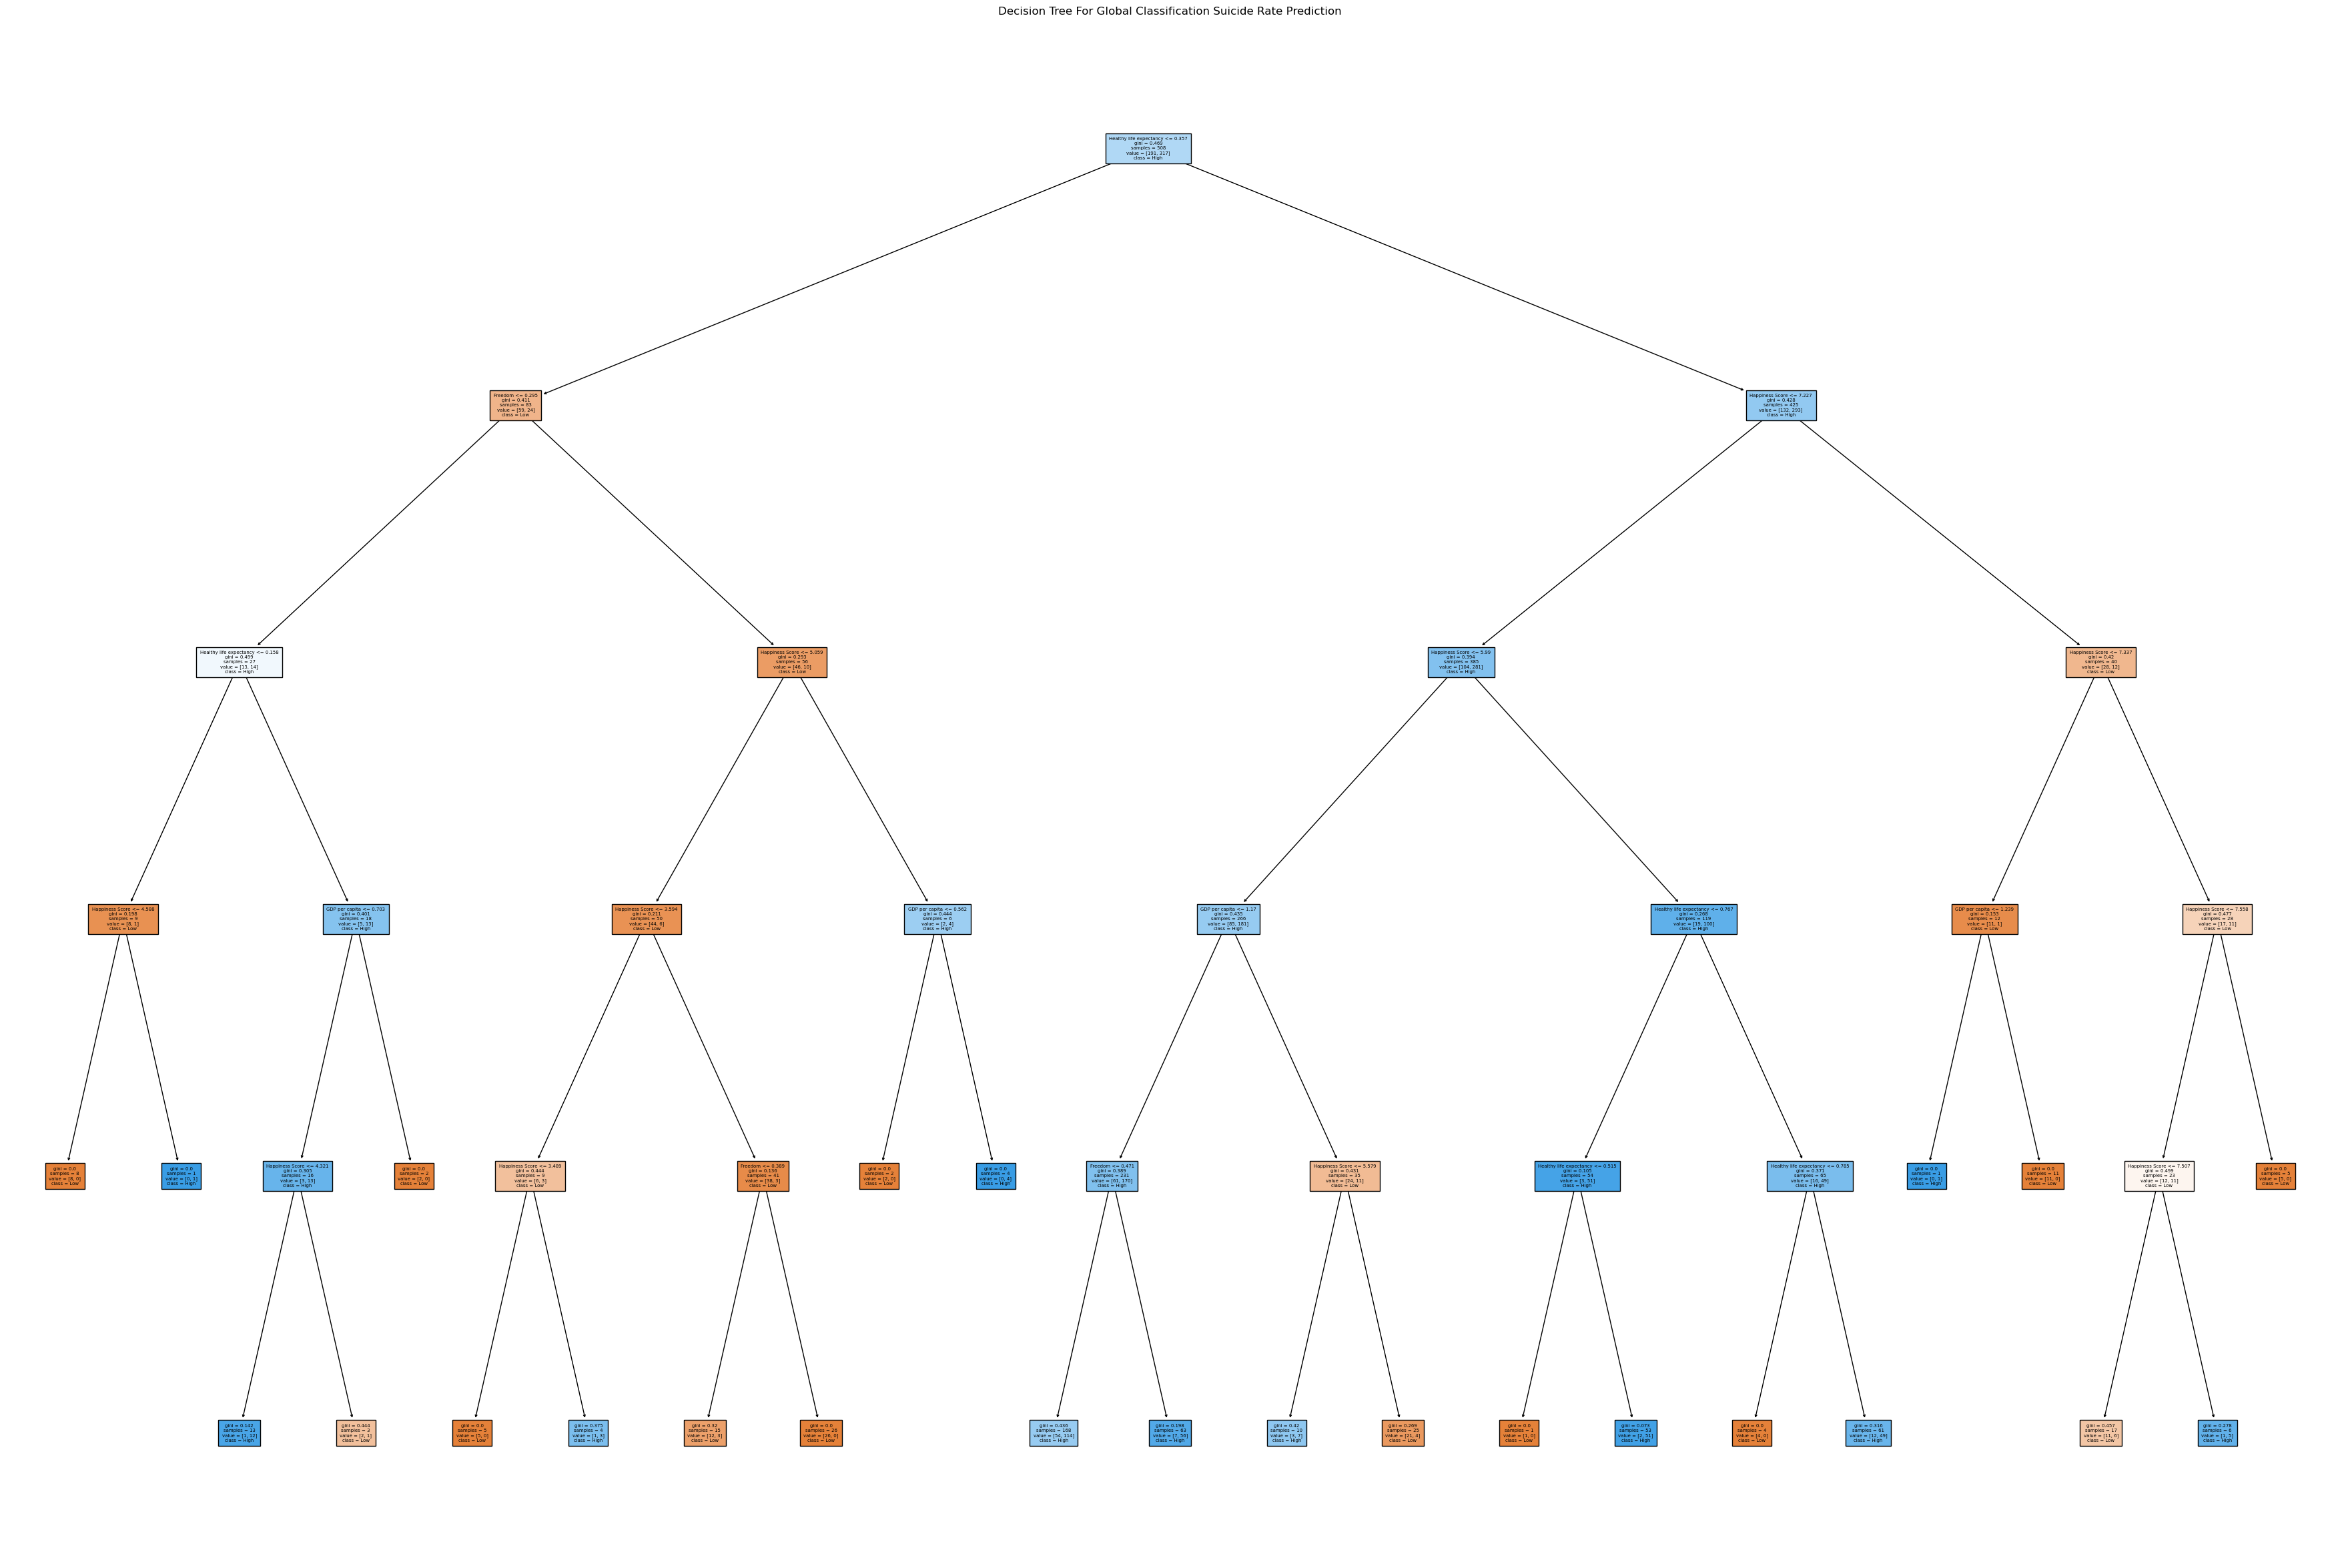


Mean squared error for the regression model of global suicide rate predictions: 3.3043056905625674


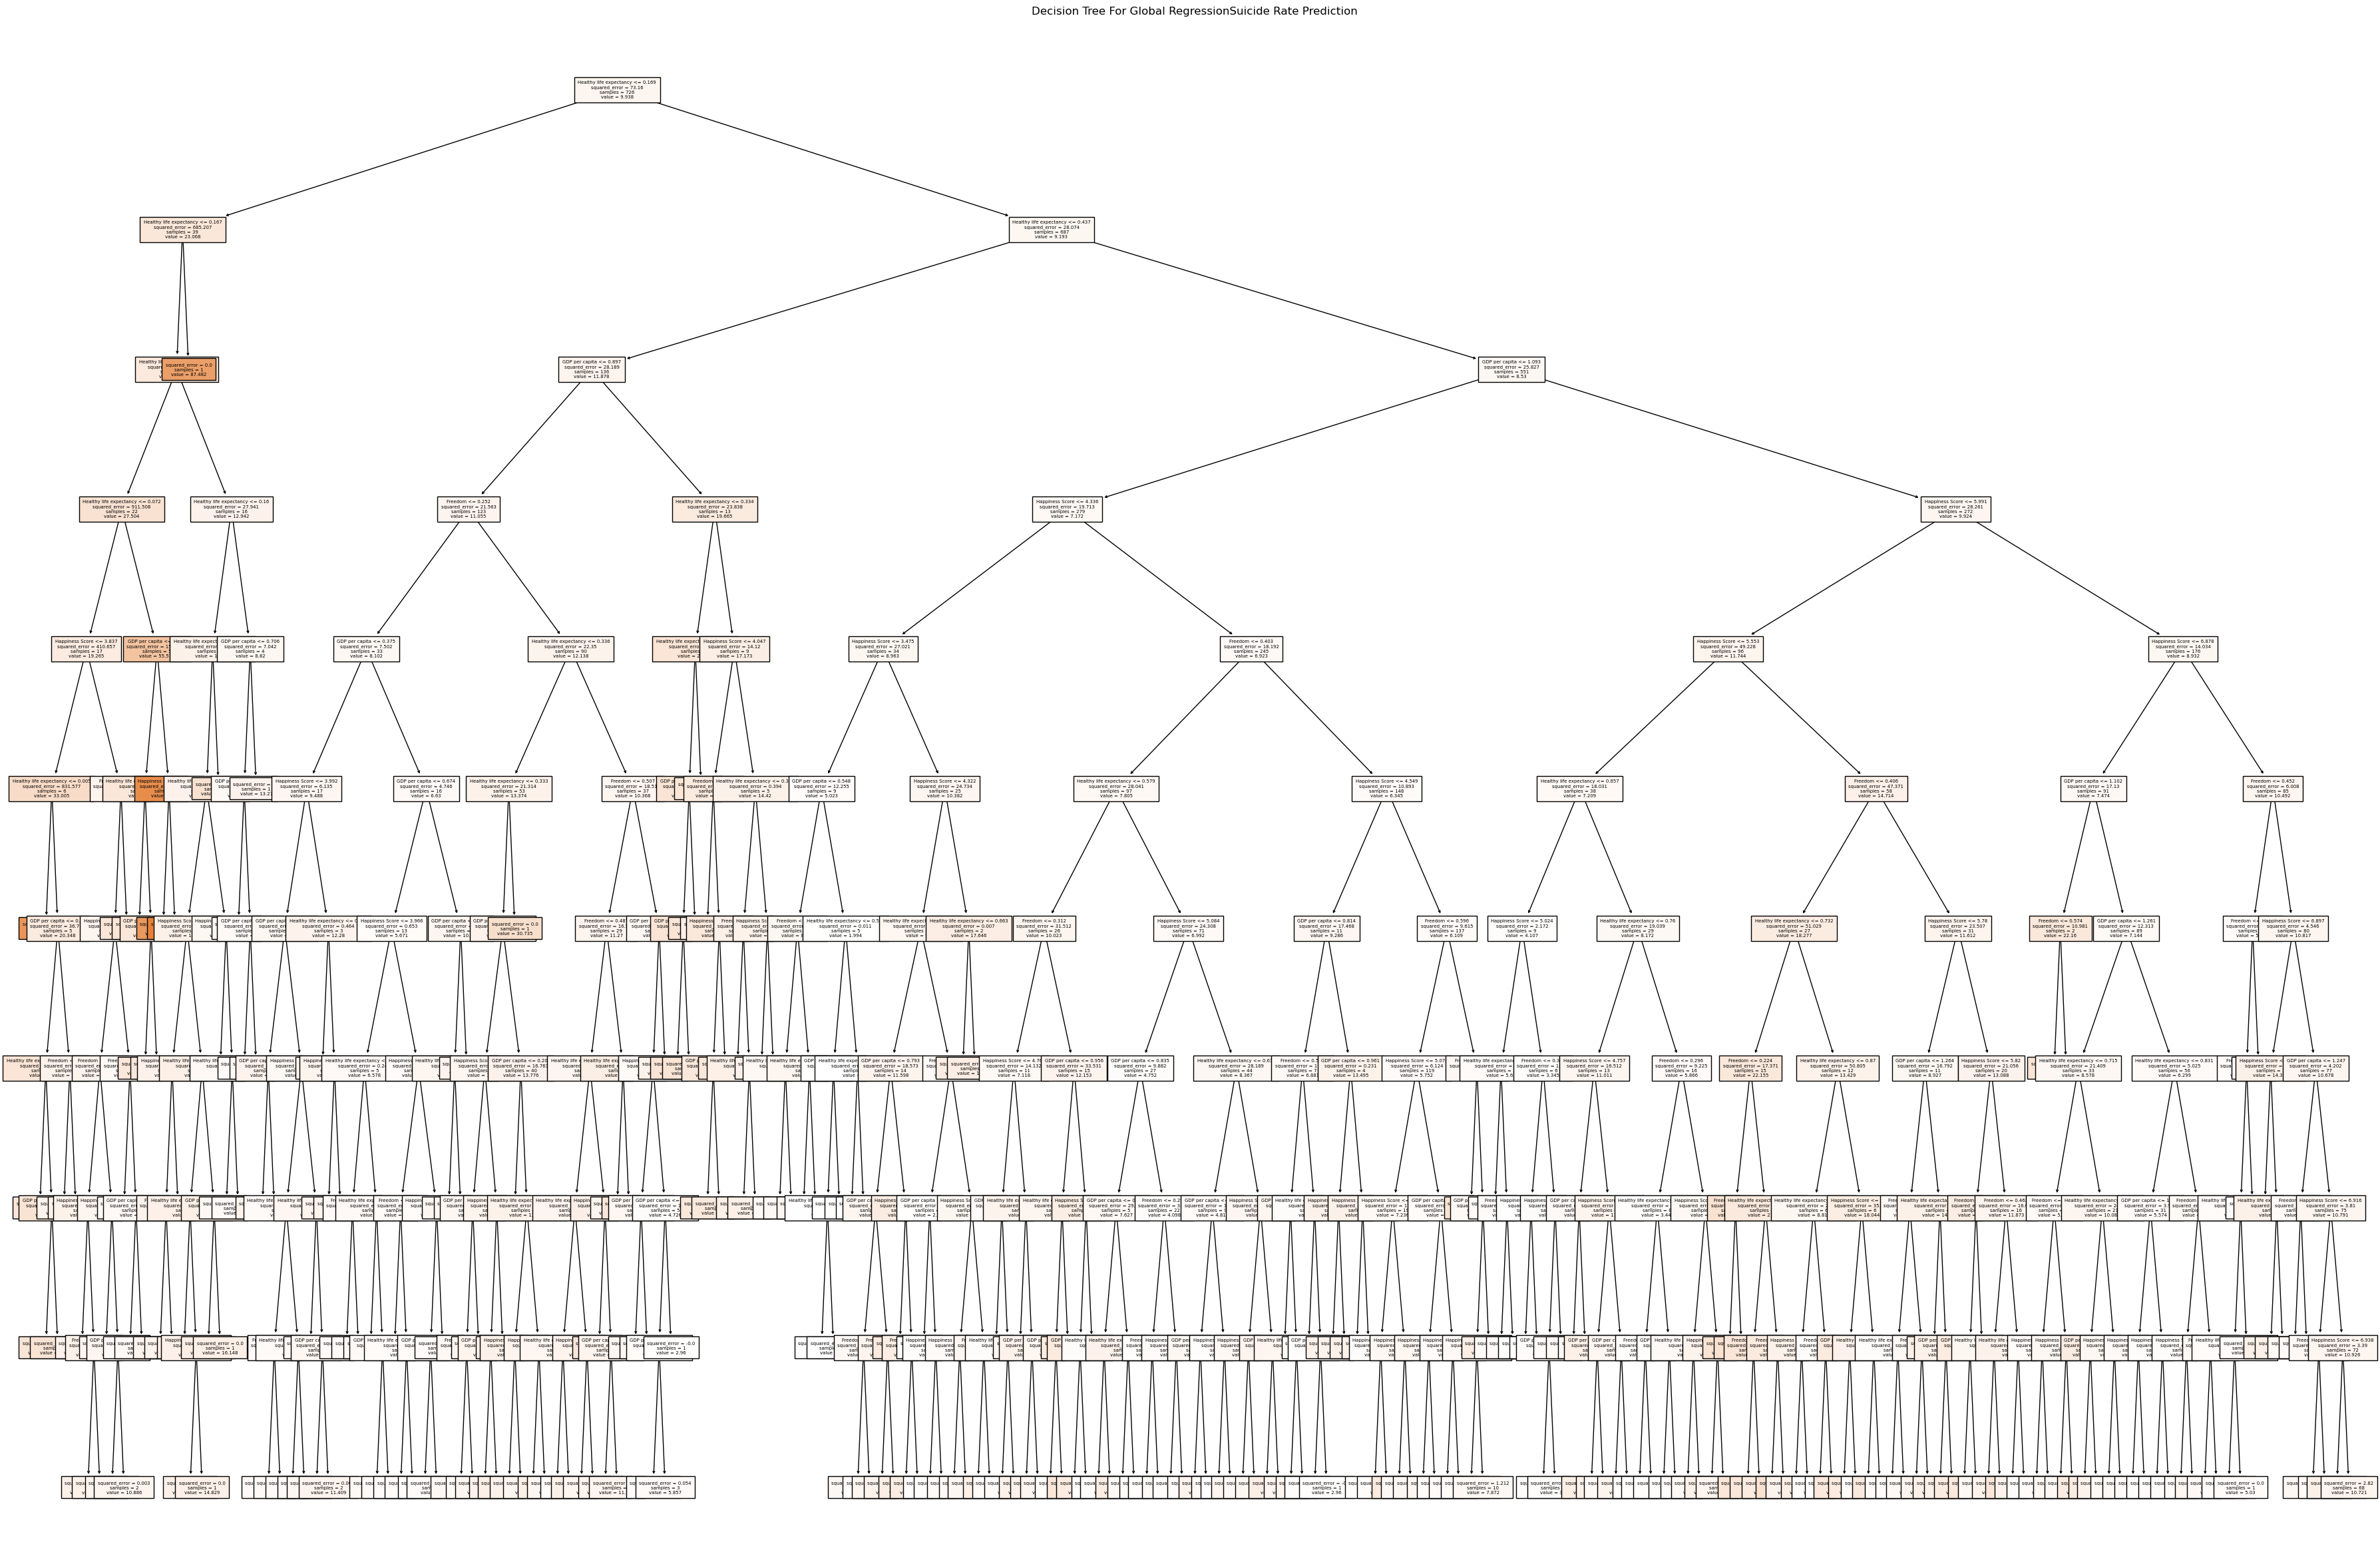

In [9]:
def main():
    happiness_suicide_df = data_cleaning()
    testing()

    # Classification model for suicide rate prediction of
    # selected region
    predict_classification_suicide_rates_regions(
        happiness_suicide_df, 'Asia'
        )
    print()
    predict_classification_suicide_rates_regions(
        happiness_suicide_df, 'Americas'
        )
    print()
    predict_classification_suicide_rates_regions(
        happiness_suicide_df, 'Europe'
        )
    print()
    predict_classification_suicide_rates_regions(
        happiness_suicide_df, 'Africa'
        )
    print()

    # Regression model for suicide rate prediction of
    # selected region
    predict_regression_suicide_regions(happiness_suicide_df, 'Asia')
    print()
    predict_regression_suicide_regions(happiness_suicide_df, 'Americas')
    print()
    predict_regression_suicide_regions(happiness_suicide_df, 'Europe')
    print()
    predict_regression_suicide_regions(happiness_suicide_df, 'Africa')
    print()

    # Classification model for global suicide rate prediction
    predict_classification_suicide_rates_Global(happiness_suicide_df)
    print()

    # Regression model for global suicide rate prediction
    predict_regression_suicide_rates_Global(happiness_suicide_df)


if __name__ == '__main__':
    main()